<a href="https://colab.research.google.com/github/ishika-mittal/Stock-Prices-Analytics-Dashboard/blob/main/Stock_Price_Prediction_using_LSTM_Network_Section_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Part 1: Data Collection**

In [1]:
#Importing Libraries
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Installing yfinance library for fetching historical stock data
!pip install yfinance
import yfinance as yf

     |████████████████████████████████| 6.3MB 7.2MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23455 sha256=30ee1bbf89bb2fd458b8fe186a09c1df359087e0bdf2cbe183d5e27e6fa3397a
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [3]:
#Function to get the stock data
def stock_data(stock, start_date, end_date):

    tickerSymbol = stock

    #get data on this ticker
    tickerData = yf.Ticker(tickerSymbol)

    #get the historical prices for this ticker
    tickerDf = tickerData.history(period='1d', start=start_date, end=end_date)

    return tickerDf

In [4]:
#Fetching data

df = stock_data("ITC.BO", "2011-06-08", "2021-06-08")
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2011-06-08,101.296763,102.791816,101.244306,102.136093,570295,0.0,0.0
2011-06-09,102.188547,102.686898,101.375440,102.267227,429328,0.0,0.0
2011-06-10,101.420746,102.267240,100.785872,101.394287,687543,1.1,0.0
2011-06-13,101.314928,101.711729,100.653608,100.971039,669849,0.0,0.0
2011-06-14,101.050409,102.796310,101.050409,102.505325,513403,0.0,0.0


## **Exploratory Data Analysis**

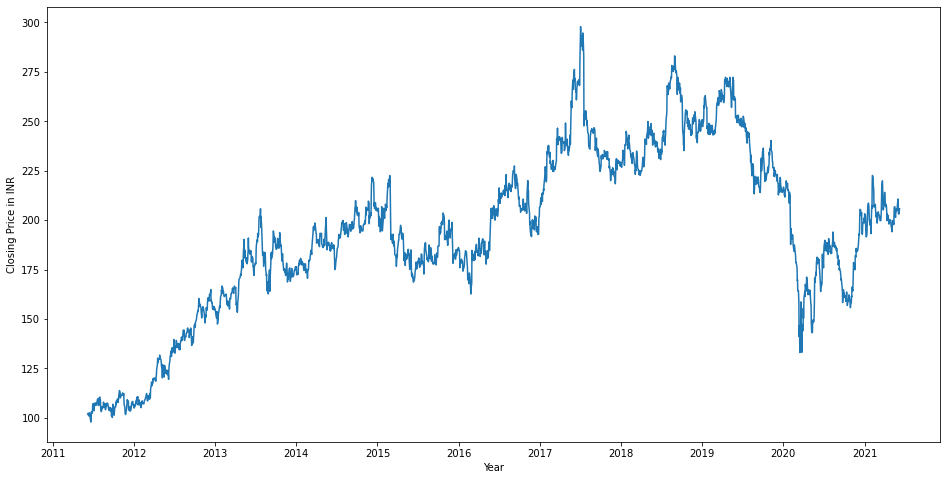

In [5]:
#plotting fetched data
fig = plt.figure(figsize=(16,8))
plt.xlabel("Year")
plt.ylabel("Closing Price in INR")
plt.plot(df['Close'], label='Close Price history')

In [6]:
#Checking the data types
df.dtypes

Open            float64
High            float64
Low             float64
Close           float64
Volume            int64
Dividends       float64
Stock Splits    float64
dtype: object

In [7]:
#Checking for data consistency, missing values, measures of central tendency, dispersion
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,2459.000000,2459.000000,2459.000000,2459.000000,2.459000e+03,2459.000000,2459.000000
mean,194.164962,196.018209,191.801647,193.811047,8.897098e+05,0.019479,0.000610
std,42.643026,42.862788,42.253953,42.430514,9.861227e+05,0.329482,0.030249
min,97.876044,98.828344,96.447576,97.902496,0.000000e+00,0.000000,0.000000
25%,173.095039,174.531831,170.534772,172.617638,3.931850e+05,0.000000,0.000000
50%,193.823091,195.793749,191.170334,193.276474,5.872400e+05,0.000000,0.000000
75%,226.322617,228.240783,224.172425,225.665733,1.022740e+06,0.000000,0.000000
max,300.448458,307.366833,296.140787,297.881256,1.312159e+07,10.150000,1.500000


## **Part 3: Data Preprocessing**

In [8]:
#Resetting index to make date a column
df.reset_index(level="Date", inplace=True)

In [9]:
#Dropping columns which are not required
df.drop(columns = ['Dividends', 'Stock Splits'], inplace=True)

In [10]:
#Creating a dataset with only Closing Price column and Date as index

data = df.sort_index(ascending=True,axis=0)
df1 = pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    df1["Date"][i]=data['Date'][i]
    df1["Close"][i]=data["Close"][i]

df1.index=df1.Date
df1.drop("Date",axis=1,inplace=True)
df1.head()

,Close
Date,
2011-06-08,102.136
2011-06-09,102.267
2011-06-10,101.394
2011-06-13,100.971
2011-06-14,102.505


In [11]:
#Splitting data into train and test, using manual spliting as time series data is ordered
data = df1.values
train = data[0:1750,:]
test = data[1750:,:]

print(train.shape)
print(test.shape)

(1750, 1)
(709, 1)


In [12]:
#LSTM is very sensitive to variance and scale of data, hence normalizing it in the range of 0-1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

In [13]:
#Preparing train data

x_train,y_train=[],[]

#Setting up a time window, the model will be using past window (in this case 60 days) of data to predict the next closing price
window = 60

for i in range(window,len(train)):
    x_train.append(scaled_data[i-window:i,0])
    y_train.append(scaled_data[i,0])

#Converting dataframe to numpy array input  
x_train,y_train = np.array(x_train),np.array(y_train)
# reshaping input to be [samples, time steps, features] which is required for LSTM
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [14]:
#Preparing test data
inputs = df1[len(df1) - len(test) - window:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

x_test = []
for i in range(window,inputs.shape[0]):
    x_test.append(inputs[i-window:i,0])

#Converting dataframe to numpy array input
x_test = np.array(x_test)
#Reshaping input to be [samples, time steps, features] which is required for LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [15]:
#Checking the input data
print(x_train[0][0])
print(y_train[0])

[0.02117023]
0.04695898948008387


## **Building the Model**

In [16]:
#importing libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [17]:
#Creating the LSTM Network

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [18]:
#Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [19]:
#Fitting the model
model.fit(x_train, y_train, epochs=1, batch_size=64, verbose=2)

27/27 - 20s - loss: 0.0212


In [20]:
#Prediction
closing_price = model.predict(x_test)
train_predict = model.predict(x_train)

##Transformback to original form
closing_price = scaler.inverse_transform(closing_price)
train_predict = scaler.inverse_transform(train_predict)

In [21]:
#Performance Metric on Test Data
import math
from sklearn.metrics import mean_squared_error

mse = math.sqrt(mean_squared_error(test,closing_price))
mse

10.47432927266533

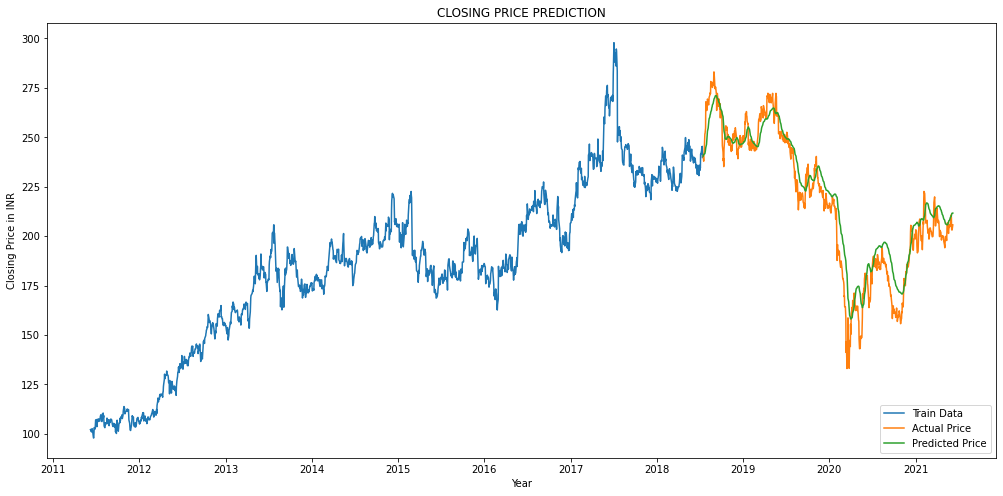

In [22]:
#Plotting the predictions
train = df1[:1750]
test = df1[1750:]
test['Predictions'] = closing_price

#Setting labels
plt.figure(figsize=(17,8))
plt.xlabel("Year")
plt.ylabel("Closing Price in INR")
plt.title("CLOSING PRICE PREDICTION")

#Let's go
plt.plot(train['Close'])
plt.plot(test[['Close','Predictions']])
plt.legend(["Train Data", "Actual Price", "Predicted Price"], loc ="lower right")
plt.show()